In [1]:
"""
Hard Hat / PPE Detection - YOLOv8 Training Pipeline
===================================================
This notebook fine-tunes YOLOv8 models for Hard Hat / PPE Detection with:
- GPU acceleration (CUDA)
- Advanced data augmentation
- Two-phase training (frozen backbone + full fine-tuning)
- Automatic batch size adjustment based on GPU memory
- Comprehensive validation and metrics

Classes: head, helmet, person
"""

from pathlib import Path
import os
import yaml
import torch
from ultralytics import YOLO

%matplotlib inline

# Paths
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_YAML = DATA_DIR / "data.yaml"
MODELS_DIR = PROJECT_ROOT / "models"
PRETRAINED_MODEL = MODELS_DIR / "yolov8s.pt"  # Start with small model

print(f"Project root: {PROJECT_ROOT}")
print(f"Data YAML: {DATA_YAML.exists()}")
print(f"Models dir: {MODELS_DIR.exists()}")

# Load dataset config
if DATA_YAML.exists():
    with open(DATA_YAML, 'r') as f:
        config = yaml.safe_load(f)
    print(f"\nDataset Configuration:")
    print(f"  Classes: {config.get('names', [])}")
    print(f"  Number of classes: {config.get('nc', 0)}")
    print(f"  Train: {config.get('train', 'N/A')}")
    print(f"  Val: {config.get('val', 'N/A')}")
    print(f"  Test: {config.get('test', 'N/A')}")
else:
    print("⚠️  data.yaml not found!")


Project root: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project
Data YAML: True
Models dir: True

Dataset Configuration:
  Classes: ['head', 'helmet', 'person']
  Number of classes: 3
  Train: train/images
  Val: valid/images
  Test: test/images


In [ ]:
# Check GPU availability and configure
import platform

device = 0 if torch.cuda.is_available() else 'cpu'
is_windows = platform.system() == 'Windows'

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n🚀 Training on GPU: {gpu_name}")
    print(f"   GPU Memory: {gpu_memory_gb:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    
    # Adjust batch size based on GPU memory
    if gpu_memory_gb >= 12:
        batch_size = 16  # 12GB+ GPU
    elif gpu_memory_gb >= 8:
        batch_size = 12  # 8GB GPU
    elif gpu_memory_gb >= 6:
        batch_size = 8   # 6GB GPU (like RTX 3060 Laptop)
    else:
        batch_size = 4   # Smaller GPUs
    print(f"   Using batch size: {batch_size}")
else:
    print("\n⚠️  GPU not available, using CPU (training will be very slow)")
    batch_size = 2  # CPU can only handle small batch size

# Windows has issues with multiprocessing DataLoader workers
# Use 0 workers on Windows to avoid memory errors
if is_windows:
    num_workers = 0
    print(f"   ⚠️  Windows detected: Using workers=0 (no multiprocessing) to avoid memory issues")
else:
    num_workers = 4 if torch.cuda.is_available() else 2
    print(f"   Using workers: {num_workers}")



🚀 Training on GPU: NVIDIA GeForce RTX 3060 Laptop GPU
   GPU Memory: 6.44 GB
   CUDA Version: 12.6
   Using batch size: 8


In [3]:
# Load or download pretrained model
print(f"\n📦 Loading YOLOv8 model...")
if PRETRAINED_MODEL.exists():
    print(f"   Using local model: {PRETRAINED_MODEL}")
    model = YOLO(str(PRETRAINED_MODEL))
else:
    print("   Model not found locally, downloading yolov8s.pt...")
    model = YOLO('yolov8s.pt')
    # Try to save to models folder
    try:
        MODELS_DIR.mkdir(parents=True, exist_ok=True)
        import shutil
        from pathlib import Path
        import ultralytics
        ultralytics_dir = Path.home() / '.ultralytics'
        cached_model = list(ultralytics_dir.rglob('yolov8s.pt'))
        if cached_model:
            shutil.copy2(cached_model[0], PRETRAINED_MODEL)
            print(f"   ✅ Model saved to: {PRETRAINED_MODEL}")
    except Exception as e:
        print(f"   ⚠️  Could not save model locally: {e}")

print("✅ Model loaded successfully")



📦 Loading YOLOv8 model...
   Using local model: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\models\yolov8s.pt
✅ Model loaded successfully


In [ ]:
# Phase 1: Training with frozen backbone (faster, good initialization)
print("\n📊 Phase 1: Training with frozen backbone (15 epochs)...")
print("   Using YOLOv8 with optimized settings for GPU memory")

train_results_phase1 = model.train(
    data=str(DATA_YAML),
    epochs=15,
    imgsz=640,  # Standard YOLO input size
    batch=batch_size,
    workers=num_workers,
    patience=20,
    # Learning rate
    lr0=0.01,
    lrf=0.01,
    weight_decay=0.0005,
    # Enhanced augmentations for PPE detection
    hsv_h=0.015,      # Hue variation
    hsv_s=0.7,        # Saturation variation
    hsv_v=0.4,        # Value/brightness variation
    degrees=10.0,     # Rotation
    translate=0.1,    # Translation
    scale=0.5,        # Scale variation
    shear=2.0,        # Shear transformation
    perspective=0.0005,  # Perspective transformation
    flipud=0.0,       # No vertical flip (people orientation matters)
    fliplr=0.5,       # Horizontal flip
    mosaic=1.0,        # Mosaic augmentation
    mixup=0.1,        # Mixup augmentation
    copy_paste=0.1,   # Copy-paste augmentation
    close_mosaic=10,
    # Regularization
    dropout=0.0,      # No dropout for frozen training
    # Freeze backbone layers
    freeze=10,        # Freeze first 10 layers
    device=device,
    project=str(PROJECT_ROOT / 'runs' / 'detect'),
    name='ppe_detection_phase1',
    exist_ok=True,
    resume=False,
    amp=True,  # Mixed precision for memory efficiency
    verbose=True,
)



📊 Phase 1: Training with frozen backbone (15 epochs)...
   Using YOLOv8 with optimized settings for GPU memory
New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.218  Python-3.13.7 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line

In [5]:
# Load best weights from Phase 1
run_dir = Path(model.trainer.save_dir) if hasattr(model, 'trainer') else None
best_w = run_dir / 'weights' / 'best.pt' if run_dir else None
last_w = run_dir / 'weights' / 'last.pt' if run_dir else None
weights_path = best_w if (best_w and best_w.exists()) else (last_w if (last_w and last_w.exists()) else None)

if weights_path is not None:
    model = YOLO(str(weights_path))
    print(f"✅ Loaded best weights from Phase 1: {weights_path}")
else:
    print("⚠️  Could not find Phase 1 weights, continuing with current model")

✅ Loaded best weights from Phase 1: C:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\ppe_detection_phase1\weights\best.pt


In [ ]:
# Phase 2: Fine-tuning with unfrozen backbone (full model training)
print("\n📊 Phase 2: Fine-tuning with unfrozen backbone (30 epochs)...")
print("   Full model training with reduced learning rate")

train_results_phase2 = model.train(
    data=str(DATA_YAML),
    epochs=30,
    imgsz=640,
    batch=batch_size,
    workers=num_workers,
    patience=25,
    # Lower learning rate for fine-tuning
    lr0=0.001,        # Reduced from Phase 1
    lrf=0.01,
    weight_decay=0.0005,
    # Moderate augmentations for fine-tuning
    hsv_h=0.01,
    hsv_s=0.5,
    hsv_v=0.3,
    degrees=5.0,
    translate=0.05,
    scale=0.3,
    shear=1.0,
    perspective=0.0003,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.8,
    mixup=0.05,
    copy_paste=0.05,
    close_mosaic=10,
    dropout=0.0,
    # Unfreeze all layers
    freeze=0,         # No freezing - train all layers
    device=device,
    project=str(PROJECT_ROOT / 'runs' / 'detect'),
    name='ppe_detection_phase2',
    exist_ok=True,
    resume=False,
    amp=True,
    verbose=True,
)

print("\n✅ Training completed!")



📊 Phase 2: Fine-tuning with unfrozen backbone (30 epochs)...
   Full model training with reduced learning rate
New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.218  Python-3.13.7 torch-2.9.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.05, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.01, hsv_s=0.5, hsv_v=0.3, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_w

RuntimeError: Caught MemoryError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\base.py", line 381, in __getitem__
    return self.transforms(self.get_image_and_label(index))
           ~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\augment.py", line 204, in __call__
    data = t(data)
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\augment.py", line 204, in __call__
    data = t(data)
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\augment.py", line 407, in __call__
    labels = self._mix_transform(labels)
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\augment.py", line 595, in _mix_transform
    self._mosaic3(labels) if self.n == 3 else self._mosaic4(labels) if self.n == 4 else self._mosaic9(labels)
                                              ~~~~~~~~~~~~~^^^^^^^^
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\ultralytics\data\augment.py", line 692, in _mosaic4
    img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
  File "c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\venv\Lib\site-packages\numpy\_core\numeric.py", line 352, in full
    a = empty(shape, dtype, order, device=device)
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 4.69 MiB for an array with shape (1280, 1280, 3) and data type uint8


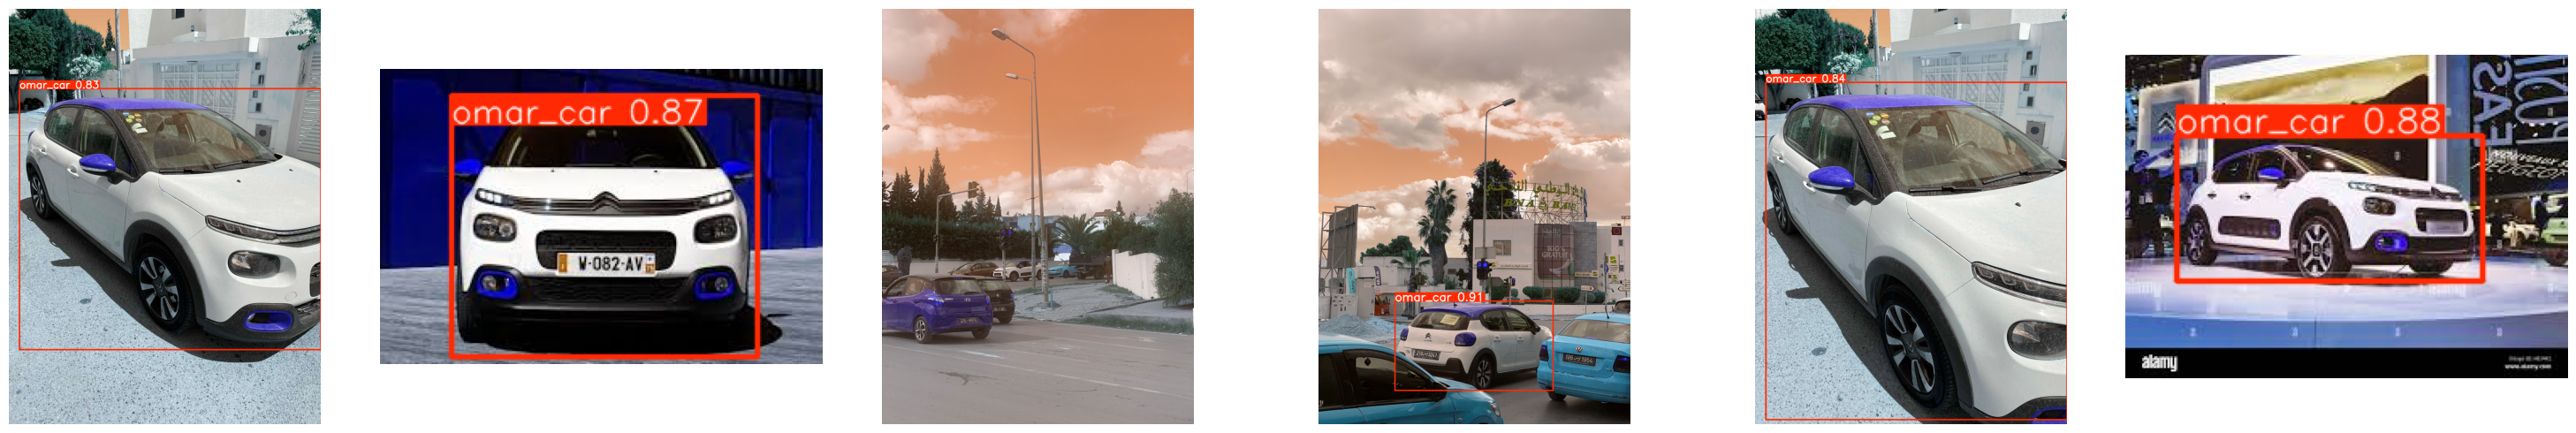

In [ ]:
# Validate best model
run_dir = Path(model.trainer.save_dir) if hasattr(model, 'trainer') else None
best_weights = run_dir / 'weights' / 'best.pt' if run_dir else None

if best_weights and best_weights.exists():
    best_model = YOLO(str(best_weights))
    print(f"\n📊 Validating best model: {best_weights}")
    
    val_results = best_model.val(
        data=str(DATA_YAML),
        imgsz=640,
        batch=batch_size,
        device=device,
        verbose=True,
    )
    
    print("\n✅ Validation complete!")
    print(f"\n📈 Results:")
    print(f"   mAP50: {val_results.box.map50:.4f}")
    print(f"   mAP50-95: {val_results.box.map:.4f}")
    print(f"   Precision: {val_results.box.mp:.4f}")
    print(f"   Recall: {val_results.box.mr:.4f}")
else:
    print("⚠️  Best weights not found")


In [ ]:
# Summary
print("\n" + "=" * 70)
print("TRAINING SUMMARY - Hard Hat / PPE Detection")
print("=" * 70)
print(f"\n✅ Training completed successfully!")
print(f"\n📁 Model saved to: {run_dir / 'weights' / 'best.pt' if run_dir else 'N/A'}")
print(f"\n💡 Next steps:")
print(f"   1. Review validation metrics")
print(f"   2. Test on test set using prediction notebook")
print(f"   3. Deploy model for inference")
print("=" * 70)



image 1/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\000000008734602.jpg: 320x640 1 omar_car, 31.9ms
image 2/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\CL 20.003.012_2021.jpg: 384x640 1 omar_car, 20.8ms
image 3/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\Citroen-C3-1.jpg: 480x640 1 omar_car, 23.4ms
image 4/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\Citroen-C3-57.jpg: 448x640 1 omar_car, 22.3ms
image 5/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\Untitled.jpeg: 448x640 1 omar_car, 20.8ms
image 6/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\images.jpeg: 320x640 1 omar_car, 16.6ms
image 7/8 c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\data\test\images1.jpeg: 352x640 2 omar_cars, 17.3ms
image 8/8 c:\Users\O

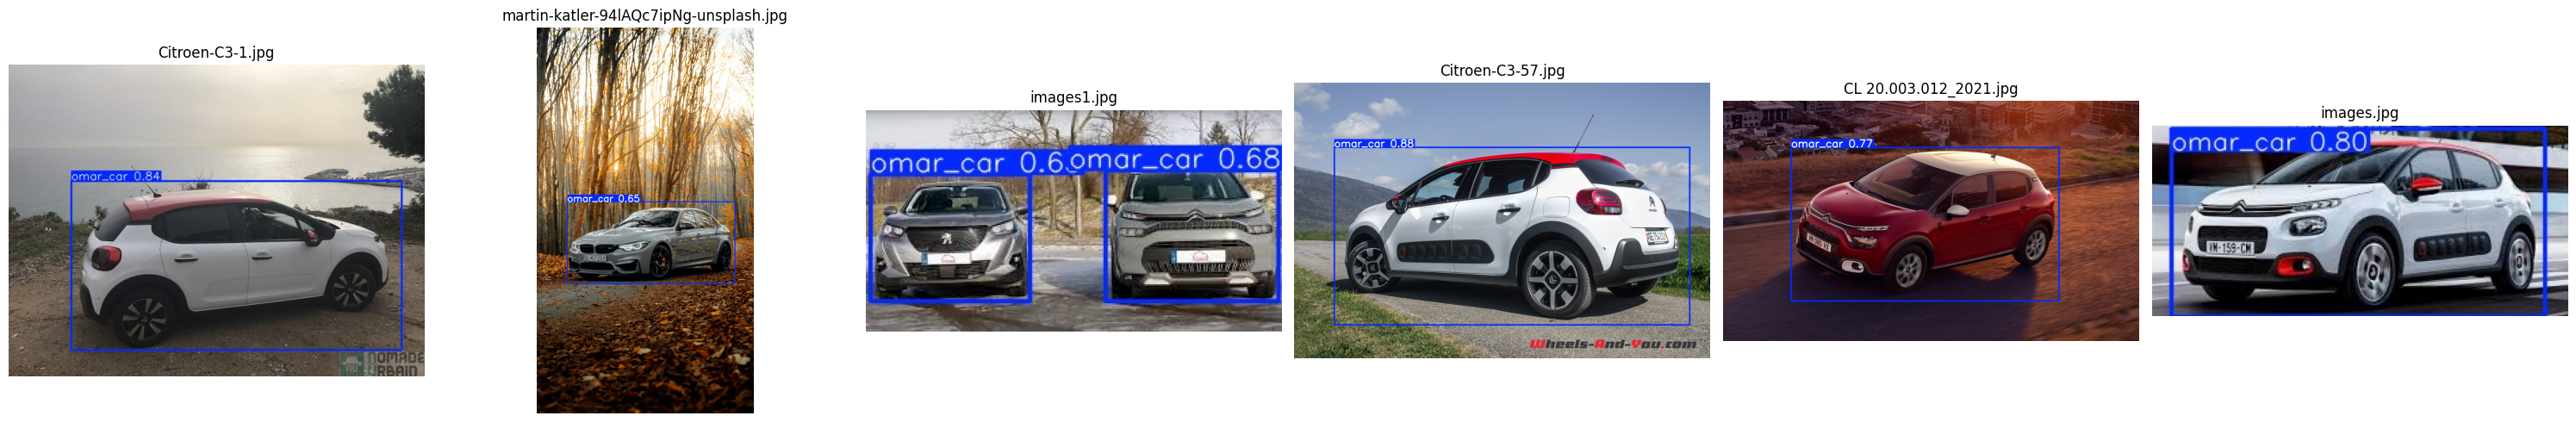

Saved predictions to: c:\Users\Omar\Desktop\ids5\object-detection-video\object_detection_project\runs\detect\test-pred


In [ ]:
# Test predictions on validation set
import random
import matplotlib.pyplot as plt
from pathlib import Path

if best_weights and best_weights.exists() and 'best_model' in globals():
    # Sample a few validation images
    val_images_dir = DATA_DIR / "valid" / "images"
    if val_images_dir.exists():
        val_images = list(val_images_dir.glob("*"))
        val_images = [f for f in val_images if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]
        
        if val_images:
            num_samples = min(6, len(val_images))
            sample_images = random.sample(val_images, num_samples)
            
            print(f"\n🔍 Running predictions on {num_samples} validation images...")
            
            pred_results = best_model.predict(
                source=[str(p) for p in sample_images],
                imgsz=640,
                conf=0.25,
                iou=0.45,
                device=device,
                verbose=False
            )
            
            # Visualize
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.flatten()
            
            for idx, (ax, res) in enumerate(zip(axes, pred_results)):
                ax.imshow(res.plot())
                ax.set_title(f"{sample_images[idx].name}", fontsize=10)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("\n✅ Predictions complete!")
        else:
            print("⚠️  No validation images found")
    else:
        print("⚠️  Validation images directory not found")
